# Single-Object Segmentation

**Object segmentation is the process of finding the boundaries of target objects in images**. There are many applications for segmenting objects in images. As an example, by outlining anatomical objects in medical images, clinical experts can learn useful information about patients' conditions. 

Depending on the number of objects in images, we can deal with single-object or multi-object segmentation tasks. This chapter will focus on **developing a deep-learning model using PyTorch to perform single-object segmentation**. In single-object segmentation, **we are interested in automatically outlining the boundary of one target object in an image**. 

**The object boundary is usually defined by a binary mask**. From the binary mask, **we can overlay a contour on the image to outline the object boundary**. As an example, the following screenshot depicts an ultrasound image of a fetus, a binary mask corresponding to the fetal head, and the segmentation of the fetal head overlaid on the ultrasound image:

![](binary_mask.png)

Other examples include the segmentation of heart chambers in MRI or CT images in order to calculate multiple clinical indices including the ejection fraction.

**The goal of automatic single-object segmentation is to predict a binary mask given in an image**. In this chapter, we will learn how to create an algorithm to automatically segment a fetal head in ultrasound images. This is an important task in medical imaging in order to measure the fetal head circumference.

## **Creating custom datasets**

We will use the data from the **Automated measurement of fetal head circumference** competition on the **Grand Challenge** website. During pregnancy, ultrasound imaging is used to measure the fetal head circumference. The measurement can be used to monitor the growth of the fetus. The dataset contains the two-dimensional (2D) ultrasound images of the standard plane. 

In this recipe, we will use the Dataset class from the torch.utils.data package to create custom datasets for loading and processing data.

### **Getting ready**

To download the dataset, visit https://zenodo.org/record/1322001#.XcX1jk9KhhE

### **How to do it**

#### **Data exploration**

In [122]:
# 1 Let's inspect the training_set folder by counting the number of images and annotations:
import os
path2train="../data/fetal-head/training_set/"

imgsList=[pp for pp in os.listdir(path2train) if pp.endswith(".png") if "Annotation" not in pp]
anntsList=[pp for pp in os.listdir(path2train) if pp.endswith(".png") if "Annotation" in pp]
print("number of images:", len(imgsList))
print("number of annotations:", len(anntsList))

number of images: 999
number of annotations: 999


In [123]:
# 2 Next, we will display a few sample images and masks:
# Select random images from the list using the following code:
import numpy as np
np.random.seed(2019)
rndImgs = np.random.choice(imgsList, 4)
rndImgs

array(['166_2HC.png', '434_HC.png', '244_HC.png', '826_3HC.png'],
      dtype='<U11')

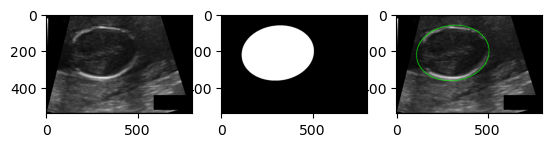

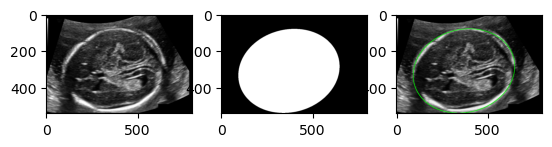

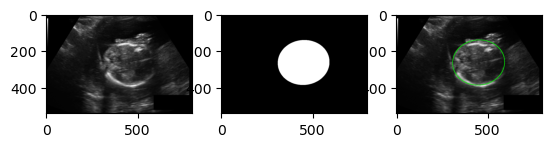

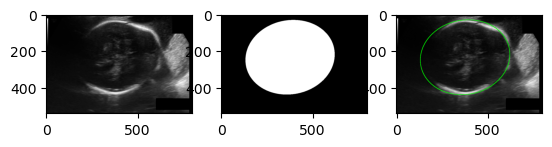

In [124]:
# Define a helper function to show an image and its annotation:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries

def show_img_mask(img, mask):
    img_mask = mark_boundaries(np.array(img), np.array(mask), outline_color=(0, 1, 0), color=(0, 1, 0))
    plt.imshow(img_mask)

# Call the helper function to display the images and masks:
for fn in rndImgs:
    path2img = os.path.join(path2train, fn)
    path2annt = path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    mask = ndi.binary_fill_holes(annt_edges) 

    plt.figure()
    plt.subplot(1, 3, 1) 
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2) 
    plt.imshow(mask, cmap="gray")

    plt.subplot(1, 3, 3) 
    show_img_mask(img, mask)

#### **Data augmentation**

We will use the albumentations package to augment the data for segmentation tasks:
1. Install the albumentations package in your conda environment:
```bash
$ conda install -c conda-forge imgaug
$ conda install albumentations -c albumentations
```

In [126]:
# 2 Import the augmentation functions:
from albumentations import (
    HorizontalFlip,
    VerticalFlip, 
    Compose,
    Resize
)

# 3 Define transform_train for the training dataset:
h, w = 128, 192
transform_train = Compose([Resize(h, w), 
        HorizontalFlip(p=0.5), 
        VerticalFlip(p=0.5),
    ])
    
# 4 Define transform_val for the validation dataset:
transform_val = Resize(h, w)

### **Creating the dataset**

In [129]:
# 1 Import the packages and define the dataset class:
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image

# Define the fetal_dataset class:
class fetal_dataset(Dataset):
    def __init__(self, path2data, transform=None): 
        imgsList = [pp for pp in os.listdir(path2data) if pp.endswith(".png") if "Annotation" not in pp]
        anntsList = [pp for pp in os.listdir(path2train) if pp.endswith(".png") if "Annotation" in pp]

        self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList] 
        self.path2annts = [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]
        self.transform = transform
    
    def __len__(self):
        return len(self.path2imgs)

    def __getitem__(self, idx):
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)

        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        mask = ndi.binary_fill_holes(annt_edges) 
            
        image = np.array(image)
        mask = mask.astype("uint8")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'] 

        image = to_tensor(image) 
        mask = 255 * to_tensor(mask) 
        return image, mask

In [130]:
# 2 Define two objects of the fetal_dataset class:
fetal_ds1 = fetal_dataset(path2train, transform=transform_train)
fetal_ds2 = fetal_dataset(path2train, transform=transform_val)
print(len(fetal_ds1))
print(len(fetal_ds2))

999
999


In [131]:
# 3 Fetch a sample image and mask from the feta_ds1 and display it:
import torch

img, mask = fetal_ds1[0]
print(img.shape, img.type(), torch.max(img))
print(mask.shape, mask.type(), torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


In [134]:
# Display the image and mask:
# show_img_mask(img, mask)

In [135]:
# 4 Split the data into two groups:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indices = range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-" * 10)
    print(len(val_index))

799
----------
200


In [136]:
# 5 Create train_ds and val_ds:
from torch.utils.data import Subset

train_ds = Subset(fetal_ds1, train_index)
print(len(train_ds))

val_ds = Subset(fetal_ds2, val_index)
print(len(val_ds))

799
200


In [137]:
# 6 Show a sample image from train_ds:
# plt.figure(figsize=(5, 5))
# for img, mask in train_ds:
#     show_img_mask(img, mask)
#     break

In [138]:
# Show a sample image and mask from val_ds:
# plt.figure(figsize=(5, 5))
# for img,mask in val_ds:
#     show_img_mask(img, mask)
#     break

In [139]:
# 7 Define the data loaders:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False) 

# 8 Get a sample batch from train_dl:
for img_b, mask_b in train_dl:
    print(img_b.shape, img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


In [140]:
# Get a sample batch from val_dl:
for img_b, mask_b in val_dl:
    print(img_b.shape, img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([16, 1, 128, 192]) torch.float32
torch.Size([16, 1, 128, 192]) torch.float32


### **How it works**

In the Data exploration subsection, we inspected the data to understand more about it. First, we got the list of images and annotations in the `training_set` folder. The annotations files have the term `Annotation` in the filename. As we previously learned, there were 999 images and 999 annotation files in the folder.

In step 2, we displayed a few random images and annotations. We defined a helper function, `show_img_mask`, to show an image and an overlay. The inputs to the helper function were as follows:

In step 2, we displayed a few random images and annotations. We defined a helper function, show_img_mask, to show an image and an overlay. The inputs to the helper function were as follows:

* `image`: A `PIL` image
* `mask`: A `PIL` or `numpy` array containing the binary mask of the object
In the function, we used mark_boundaries from the `skimage.segmentation` package to overlay the mask on the image.

> Note that the annotation files contain the edges of the fetal head. As such, we converted the edges to binary masks using the binary_fill_holes function from the scipy.ndimage package. The screenshot displayed original ultrasound images on the left, binary masks of the fetal heads in the middle, and the image overlay on the right.

In the Data augmentation subsection, we used a popular Python package called `albumentations` for data transformation. For the first time, you needed to install the package, as shown in step 1. Make sure that you install the package in the conda environment that we created for this book. The package has a rich set of various augmentation and transformation techniques. In step 2, we imported a few of these packages. Next, for the training dataset, we composed a vertical and horizontal flip, resizing the images to $128 \times 192$. For the validation dataset, we only performed the resizing transformation. We will pass these transformations to the PyTorch dataset class in the next subsection.

In Creating the dataset class subsection, we used the `Dataset` class from the `torch.utils.data` package to create custom training and validation datasets. In step 1, we defined the `fetal_dataset` class. The class has three functions. The first function is the `__init__` function with three inputs, which were as follows:
* `path2data`: A string, the location of the data
* `transform`: The transformation function

In the function, we got the list of images and annotations and initialized the variables.

The second function of the class, `__len__`, returns the length of the dataset. Finally, the `__getitem__` function loads the image and annotation files and returns the image and binary mask. Note that we converted the arrays to PyTorch tensors using the `to_tensor` function at the end. The `to_tensor` function normalizes the values by diving them to $255$. As such, we scaled back the mask values to the range of $[0, 1]$ by multiplying it by $255$.

In step 2, we defined two objects of the `fetal_dataset` class by passing `transform_train` and `transform_val` to the class, respectively. As expected, the length of both `fetal_ds1` and `fetal_ds2` is 999.

In step 3, we fetched and displayed an image and a mask from `fetal_ds1`. Note the shape, type, and maximum value in the image and mask. As you can see, the image and mask have been resized to $128 \times 192$, which are of the torch.FloatTensor type, and have a maximum value of 1.

In step 4, we created two lists of `train_index` and `val_index` by separating 20 percent of the indices from the total indices.

In step 5, we passed the train_index and val_index to the Subset class from the torch.utils.data package to create the training and validation datasets, respectively.

In step 6, we displayed the sample image and mask from `train_ds` and `val_ds`, respectively.

In step 7, we defined two data loaders, `train_dl`, and `val_dl`, using the DataLoader class to be able to fetch data batches from the training and validation datasets during training.

In step 8, we got a data batch from `train_dl` and `val_dl`, and printed their respective shapes. As we saw, tensors of size `[batch_size, 128, 192]` were returned from the data loaders.

## **Defining the model**

<font color=yellow>**The popular model architecture for segmentation tasks is the so-called encoder–decoder model</font>**, as shown in the following screenshot:

![](encoder_decoder.png)

In the <font color=yellow>**first half of the encoder–decoder model, the input image is downsized to a feature map using a few layers of convolutional neural networks (CNNs) and pooling layers</font>**. In <font color=yellow>**the second half of the model, the feature map is up-sampled to the input image size to produce a binary mask</font>**. The **encoder–decoder model** was **further updated based on the concept of skip-connections from ResNet to another popular architecture called U-Net**. In this recipe, we will learn how to develop an encoder–decoder model for single-object image segmentation using PyTorch.

### **How to do it**

We will first define the model class and print the model.

In [141]:
# 1 Let's define the model class. First, import the required packages:
import torch.nn as nn
import torch.nn.functional as F
# Then, define the SegNet class:

class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()
        
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"] 
        num_outputs=params["num_outputs"] 

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3, padding=1)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3, padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3, padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3, padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3, padding=1)
        
        self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3, padding=1)

    def forward(self, x):        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv5(x))
        
        x=self.upsample(x)
        x = F.relu(self.conv_up1(x))
        
        x=self.upsample(x)
        x = F.relu(self.conv_up2(x))
        
        x=self.upsample(x)
        x = F.relu(self.conv_up3(x))
        
        x=self.upsample(x)
        x = F.relu(self.conv_up4(x))
        
        x = self.conv_out(x)        
        return x

# Define an object of the SegNet class:
params_model = {
        "input_shape": (1, h, w),
        "initial_filters": 16, 
        "num_outputs": 1,
    }

model = SegNet(params_model)

# 3 Move the model to the GPU device, if available:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 4 Print the model:
print(model)

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [142]:
# 5 Show the model summary:
from torchsummary import summary
summary(model, input_size=(1, h, w), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 192]             160
            Conv2d-2           [-1, 32, 64, 96]           4,640
            Conv2d-3           [-1, 64, 32, 48]          18,496
            Conv2d-4          [-1, 128, 16, 24]          73,856
            Conv2d-5           [-1, 256, 8, 12]         295,168
          Upsample-6          [-1, 256, 16, 24]               0
            Conv2d-7          [-1, 128, 16, 24]         295,040
          Upsample-8          [-1, 128, 32, 48]               0
            Conv2d-9           [-1, 64, 32, 48]          73,792
         Upsample-10           [-1, 64, 64, 96]               0
           Conv2d-11           [-1, 32, 64, 96]          18,464
         Upsample-12         [-1, 32, 128, 192]               0
           Conv2d-13         [-1, 16, 128, 192]           4,624
           Conv2d-14          [-1, 1, 1

### **How it works**

In step 1, we defined the model class, `SegNet`. We first imported the required packages. The model class was built of the `__init__` and forward functions. The input to this function is a Python dictionary that contains the model parameters:

* `params`: A Python dictionary containing the model parameters
The dictionary keys are as follows:

* `inupt_shape`: A tuple, the model input shape `(1, height, width)`
* `initial_filters`: An integer, the number of filters in the first CNN layer
* `num_outputs`: An integer, the number of output channels; pass 1 for single-object segmentation
In the `__init__` function, we defined the building blocks of the model. This included five CNN blocks for down-sampling the input, an up-sampling block, and another five CNN blocks for up-sampling the feature map.

In the `forward` function, we defined the connection between the layers. The input to the `forward` function is a tensor with a `(batch_size, 1, height, width)` shape. As we saw, the input image goes through the CNN and max-pooling blocks and is then up-sampled to the input image size.

> Note that no activation function was applied to the output layer in the model definition.

In step 2, we defined an object of the `SegNet` class and called it `model`. In step 3, we moved the model to the GPU device if the device was available. In step 4, we printed the model. In step 5, we printed the model summary using the `torchsummary` package.

## **Defining the loss function and optimizer**

So far, we have created a dataset and a model. **To train the model, we need to define a loss function and an optimizer to update the model parameters based on the gradients of the loss**. The **classical loss function for single-object segmentation is the binary cross-entropy (BCE) loss function**. The BCE loss function **compares each pixel of the prediction with that of the ground truth**; however, **we can combine multiple criteria to improve the overall performance of segmentation tasks**. **A popular technique is to combine the dice metric with the BCE loss**. The **dice metric is commonly used to test the performance of segmentation algorithms by calculating the amount of overlap between the ground truth and the prediction**. In this section, you will learn how to develop a combined loss function. Then, you will define the optimizer to automatically update the model parameters during training.

### **How to do it**

We will develop the combined loss function, an optimizer, and a learning rate schedule:

In [143]:
# 1 Define a helper function to calculate the dice metric:
def dice_loss(pred, target, smooth=1e-5):
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) 
    dice = 2.0 * (intersection + smooth) / (union + smooth) 
    loss = 1.0 - dice
    return loss.sum(), dice.sum()

# 2 Define a helper function to calculate the combined loss per data batch:
import torch.nn.functional as F

def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction='sum')
    pred = torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    loss = bce + dlv
    return loss

# 3 Define the metrics_batch helper function:
def metrics_batch(pred, target):
    pred = torch.sigmoid(pred)
    _, metric = dice_loss(pred, target)
    return metric

# 4 Let's define the loss_batch helper function:
def loss_batch(loss_func, output, target, opt=None): 
    loss = loss_func(output, target)
    _, metric_b = dice_loss(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

# 5 Define the optimizer:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)
# 6 Define the learning rate schedule:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

### **How it works**

In step 1, we defined the dice_loss helper function to calculate the dice loss value. The inputs to the function were as follows:

* `pred`: A tensor with a `(batch_size, 1, height, width)` shape, corresponding to predictions
* `target`: A tensor with a `(batch_size, 1, height, width)` shape, corresponding to the ground truth
The function calculates the dice value per data batch. The dice value is between $[0, 1]$, where a value of $1$ represents a perfect overlap between the prediction and the ground truth. The dice loss is calculated as `(1- dice)`, since we wanted to minimize the value. The function returns the sum of loss values per data batch.

In step 2, we defined the `loss_func` helper function to compute the combined loss value per data batch. The function has two inputs:

* `pred`: A tensor with a `(batch_size, 1, height, width)` shape, corresponding to predictions
* `target`: A tensor with a `(batch_size, 1, height, width)` shape, corresponding to the ground truth
In the function, we first calculated the binary cross-entropy loss. Next, we calculated the dice loss and returned the sum of the two losses per data batch.

> Note that the `sigmoid` operation is integrated into the `binary_cross_entropy_with_logits` function. Remember that the model output does not include the `sigmoid` activation function. 

In step 3, we defined the `metrics_batch` helper function to compute a metric per batch. You can calculate any metric you want inside this helper function. We calculated the dice metric by calling the `dice_loss` helper function. The dice metric is a popular metric for evaluating segmentation tasks.

In step 4, we defined the `loss_batch` helper function. The inputs to the helper function are as follows:
* `loss_func`: Combined loss function defined in step 2
* `output`: A tensor with a `(batch_size, 1, height, width)` shape containing predictions
* `target`: A tensor with a `(batch_size, 1, height, width)` shape containing the ground truth
* `opt`: An object of the optimizer
In the function, we calculated the loss and metric values per data batch. During training, the optimizer object is passed to the helper function, and, as a result, the model parameters are updated using `opt.step()`. 

In step 5, we defined the `Adam` optimizer to optimize the model during training.

In step 6, we defined the learning rate schedule to automatically reduce the learning rate during training in case of a plateau.

## **Training the model**

So far, we have learned how to create the training and validation datasets, build the model, and define the loss function and optimizer. At this point, it is time to train the model. This is an iterative process. In each iteration, we select a data batch from the training dataset. We then feed the data to the model to get the model output. Then, we calculate the loss value. Next, we compute the gradients of the loss function with respect to the model parameters (also known as weights). Finally, the optimizer updates the parameters based on the gradients, and this loop continues. We also use the validation dataset to monitor the model performance during training. We will stop the training process when the performance plateaus. For better code readability, we will define a few helper functions.

### **How to do it**

In [144]:
# 1 Define the loss_epoch helper function:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # xb = xb.unsqueeze(1).type(torch.float32).to(device)
        # yb = yb.unsqueeze(1).type(torch.float32).to(device)
        xb = xb.type(torch.float32).to(device)
        yb = yb.type(torch.float32).to(device)
        
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b        

        if metric_b is not None:
            running_metric += metric_b
        if sanity_check is True:
            break
    
    loss = running_loss/float(len_data)
    metric = running_metric/float(len_data)
    return loss, metric

# 2 Define the train_val helper function:
import copy
def train_val(model, params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]    

    loss_history = {
        "train": [],
        "val": []
    }
    metric_history={
        "train": [],
        "val": []
    } 
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr)) 
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric) 
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            
        print("train loss: %.6f, dice: %.2f" %(train_loss, 100*train_metric))
        print("val loss: %.6f, dice: %.2f" %(val_loss, 100*val_metric))
        print("-"*10) 

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history 

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [145]:
# 3 Now, let's call the train_val function to train the model:
path2models= "../models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train = {
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models + "fetal_weights.pt",
}

model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 11882.692702, dice: 107.99
val loss: 8094.349063, dice: -3.14
----------
Epoch 1/99, current lr=0.0003
Copied best model weights!
train loss: 6945.173381, dice: -19.84
val loss: 6085.585176, dice: -25.60
----------
Epoch 2/99, current lr=0.0003
Copied best model weights!
train loss: 5248.786581, dice: -32.44
val loss: 5011.409316, dice: -62.50
----------
Epoch 3/99, current lr=0.0003
train loss: 4391.643067, dice: -51.58
val loss: 5730.185586, dice: -12.48
----------
Epoch 4/99, current lr=0.0003
Copied best model weights!
train loss: 3824.921765, dice: 67.39
val loss: 3667.304541, dice: -78.08
----------
Epoch 5/99, current lr=0.0003
Copied best model weights!
train loss: 3236.318475, dice: -69.86
val loss: 3639.480371, dice: -34.23
----------
Epoch 6/99, current lr=0.0003
Copied best model weights!
train loss: 2928.608055, dice: -72.48
val loss: 3084.995869, dice: -92.86
----------
Epoch 7/99, current lr=0.0003
Copi

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 3.00 GiB total capacity; 1.93 GiB already allocated; 0 bytes free; 2.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# 4 Let's plot the progress of the training and validation losses:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [ ]:
# It will also plot the progress of the dice values:

plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), metric_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), metric_hist["val"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

### **How it works**

In step 1, we defined the loss_epoch helper function. The function inputs are as follows:

* `model`: An object of the model 
* `loss_func`: An object of the loss function
* `dataset_dl`: An object of the data loader
* `sanity_check`: A Boolean flag; default value is False
* `opt`: An object of the optimizer
In the function, we extracted data batches from the data loader as xb and yb tensors. Next, we obtained the model output and calculated the loss and metric values per data batch. We repeated the process for the entire dataset and returned the average loss and metric values.

In step 2, we defined the `train_val` helper function. The inputs to the function are as follows:

* `model`: An object of the mode
* `params`: A Python dictionary containing the training parameters

In the function, we trained the model for `num_epochs` iterations. In each iteration, we set the model in train mode and trained the model for an epoch. Then we evaluated the model on the validation dataset. We stored the model parameters if the validation results were improved in each iteration. We also used the learning rate schedule to reduce the learning rate if the validation performance reached a plateau. The function returned the trained model and two dictionaries containing the loss and metric values for each iteration.

In step 3, we set the training parameters in `params_train` and called the `train_val` function to train the model.

In step 4, we plotted the results of the training and validation loss values to see the progress of training over multiple epochs.

## **Deploying the model**

Once the training is complete, you will want to deploy the model on new data. In this recipe, you will learn how to deploy the model on the test_set images. We will assume that you want to deploy the model for inference in a new script separate from the training scripts.

In this case, the model does not exist in memory. To avoid repetition, we will skip the model definition

### **How to do it**

We will load a few images from the `test_set` dataset, feed them to the trained model, and then display the outputs:

In [ ]:
# 1 Get a list of images in the test_set folder:
import os
path2test = "../data/fetal head/test_set"
imgsList = [pp for pp in os.listdir(path2test) if "Annotation" not in pp]
print("number of images:", len(imgsList))

In [ ]:
# 2 Get a few random images:
import numpy as np
np.random.seed(2019)
rndImgs = np.random.choice(imgsList, 4)
rndImgs

In [ ]:
# 3 Load the trained weights into the model:
path2weights="../models/fetal_weights.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()

# 4 Load the images and feed them to the model:
from torchvision.transforms.functional import to_tensor, to_pil_image

for fn in rndImgs:
    path2img = os.path.join(path2train, fn)
    img = Image.open(path2img)
    img = img.resize((w, h))
    img_t = to_tensor(img).unsqueeze(0).to(device)
    pred=model(img_t)
    pred=torch.sigmoid(pred)[0]
    mask_pred= (pred[0]>=0.5)

    # Display the image and the predicted output:

    plt.figure()
    plt.subplot(1, 3, 1) 
    plt.imshow(img, cmap="gray")
    plt.subplot(1, 3, 2) 
    plt.imshow(mask_pred, cmap="gray")
    plt.subplot(1, 3, 3) 
    show_img_mask(img, mask_pred)

### **How it works**

In step 1, we got the list of images in the `test_set` folder. As you saw, there were $335$ png images. There were no annotation files for the test set.

In step 2, we picked four random images.

In step 3, we loaded the trained weights into the model. The model was set in the evaluation mode using the `eval` method.

In step 4, we loaded the images one by one and fed them to the model. Before we fed an image to the model, we resized it to $(128, 192)$ and converted it to a PyTorch tensor. The model output was then passed to the `sigmoid` activation function and compared to a $0.5$ threshold to get a binary mask. Next, we displayed the image, predicted the binary mask, and predicted the contours that were overlaid on the image. As you saw, the model was able to accurately detect the fetal head in ultrasound images.